In [1]:
from __future__ import print_function
from __future__ import division

In [2]:
%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
# better-looking plots
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.figsize'] = (10.0, 8)
plt.rcParams['font.size'] = 18
mpl.ticker.AutoLocator.default_params['nbins'] = 5
mpl.ticker.AutoLocator.default_params['prune'] = 'both'

In [3]:
import numpy as np
from astropy.io import fits
from astropy.table import Table
from scipy.stats import binned_statistic, scoreatpercentile
import pickle
from scipy.optimize import minimize

In [28]:
import params

source_directory = params.source_directory
save_directory = params.numpy_save_directory
full_sample = params.full_sample
volume_limited_sample = params.volume_limited_sample
question = params.question
question_dictionary = params.question_dictionary
bins_to_plot = params.bins_to_plot
print('Question to be debiased: {}'.format(question))

min_log_fv = -1.5#np.log10(0.1)
max_log_fv = 0.1 #np.log10(0.9)

#min_log_fv = np.log10(0.1)
#max_log_fv = np.log10(0.8)

Question to be debiased: t01_smooth_or_features


In [5]:
all_data = fits.getdata(source_directory + full_sample,1)
vl_data = fits.getdata(source_directory + volume_limited_sample,1)
all_data = Table(all_data)
vl_data = Table(vl_data)
print('Loaded galaxy data...')

with open(source_directory+question_dictionary, 'rb') as h:
    questions = pickle.load(h)
print('Loaded question dictionary...')
# Stuff obtained from the voronoi code:
all_voronoi = fits.getdata(save_directory+'bins.fits',1)
all_voronoi = Table(all_voronoi)
vbins_table = fits.getdata(save_directory+'vbins_table.fits',1)
vbins_table = Table(vbins_table)
print('Loaded voronoi bins...')

Loaded galaxy data...
Loaded question dictionary...
Loaded voronoi bins...


In [6]:
# Make a table for writing in data if none already exist:
if os.path.isfile(save_directory+'full_sample_debiased.fits') is True:
    all_data_save = fits.getdata(save_directory+'full_sample_debiased.fits',1)
    all_data_save = Table(all_data_save)
else:
    all_data_save = Table()
    
if os.path.isfile(save_directory+'vl_sample_debiased.fits') is True:
    vl_data_save = fits.getdata(save_directory+'vl_sample_debiased.fits',1)
    vl_data_save = Table(vl_data_save)
else:
    vl_data_save = Table()

In [7]:
def make_figure_directory(name):
    full_name = 'figures/' + question + '/' + name + '/'
    if os.path.isdir(full_name) is False:
        os.mkdir(full_name)
        print('Made directory:' + full_name)
    return None

os.mkdir('figures/' + question + '/') if os.path.isdir('figures/' + question + '/') is False else None
for name in ['fitted_results','fit_setups','kc_fitted_functions','debiased_plots']:
    make_figure_directory(name)

In [8]:
## from 01_select.py

def select_data_arm_number(data,debiased,question,questions,N_cut=5,p_cut=0.5):
    
    pre_questions = questions[question]['pre_questions']
    pre_answers = questions[question]['pre_answers']
    
    strings = [pre_questions[s] + '_' + pre_answers[s] for s in range(len(pre_answers))]
    p_strings = [s + '_debiased' for s in strings]
    N_string = strings[-1] + '_count'

    p_values = np.ones(len(data))
    N_values = np.ones(len(data))

    for Q in p_strings:
        p_values = p_values*debiased[Q]
    N_values = N_values*data[N_string]

    select = (p_values > p_cut) & (N_values >= N_cut)
    
    print('{}/{} ({}%) galaxies selected in sample with p>{} and N>={}.'.format(np.sum(select),len(select),
                                                                               100*np.sum(select)/len(select),p_cut,N_cut))
    
    return select

In [9]:
## from 11_voronoi_assignment.py

def redshift_binning(data,voronoi_bins,question,questions,min_gals=50):
    
    answers = questions[question]['answers']
    morph_fv_cols = ['{}_{}_weighted_fraction'.format(question, a) 
                     for a in answers]
    redshift = data['REDSHIFT_1']
    z_bins = np.zeros((len(morph_fv_cols), len(data)), np.int)

    for N in np.unique(voronoi_bins):
        inbin = voronoi_bins == N

        for m, fv_col in enumerate(morph_fv_cols):
            # Select bins such that >= min_gals objects
            # with at least one vote are in each bin
            has_morph = data[fv_col][inbin] > 0
            n_with_morph = (has_morph).sum()
            n_zbins = n_with_morph / min_gals 
            n_zbins = max(n_zbins, 5)
            z = redshift[inbin]
            z_with_morph = z[has_morph]
            z_with_morph.sort()
            bin_edges = np.linspace(0, len(z_with_morph)-1, n_zbins+1, dtype=np.int)
            z_edges = z_with_morph[bin_edges]
            z_edges[0] = 0
            z_edges[-1] = 1
            z_bins[m, inbin] = np.digitize(z, z_edges)

    return z_bins

In [10]:
def save_bin_assignments(v_bins, z_bins, question='t11_arms_number'):
    assignments = Table(data=[v_bins], names=['vbin'])
    for m in range(len(z_bins)):
        zcol = 'zbin_{}'.format(m)
        assignments[zcol] = z_bins[m]
    assignments.write(save_directory + 'bin_assignments_{}.fits'.format(question),
                      overwrite=True)
    return assignments

In [11]:
question = 't01_smooth_or_features'

if questions[question]['pre_questions'] != None:
    select = select_data_arm_number(all_data,all_data_save,question,questions)
    data = all_data[select]
    voronoi = all_voronoi[select]

else:
    data = all_data
    voronoi = all_voronoi
    print('Primary question, so all {} galaxies used for debiasing.'.format(len(data)))

Primary question, so all 248883 galaxies used for debiasing.


In [12]:
redshift_bins = redshift_binning(data, voronoi['voronoi_bin'],question,questions)
bin_assignments = save_bin_assignments(voronoi['voronoi_bin'],redshift_bins,question)

In [32]:
def make_setup_dictionary(question,questions,function_dictionary=function_dictionary,
                          plot=True,min_log_fv=min_log_fv,max_log_fv=max_log_fv):

    fit_setup = {}
    fit_setup['func'] = {None: f_logistic}
    fit_setup['bounds'] = {None: params.logistic_bounds}
    fit_setup['p0'] = {None:[3,-3]}

    n_morph = len(questions[question]['answers'])
    fig,axes = make_axes(n_morph)

    fractions = [question + '_' + s + '_weighted_fraction' for s in questions[question]['answers']]
    counts = [question + '_' + s + '_count' for s in questions[question]['answers']]

    for m in range(n_morph):
    
        p_values = np.log10(np.sort(data[fractions[m]]))
        n = len(p_values)
        cumfrac = np.linspace(0,1,n)
        D = Table(np.array([cumfrac,p_values]).T,names=('cumfrac','log10fv'))
        D_fit = D[(D['log10fv'] > min_log_fv) & (D['log10fv'] < max_log_fv)] # usually see a 'levelling off' ath the
    # low end, so don't fit this.
    
        axes[m].plot(D['log10fv'],D['cumfrac'],'k-',linewidth=2)
        
        chisqs = []
        best_kcs = []
        
        for f in range(len(function_dictionary['func'])):
        
            p0 = function_dictionary['p0'][f]
            func = function_dictionary['func'][f]
            bounds = function_dictionary['bounds'][f]
            
            res = minimize(chisq_fun,x0=p0,
                               args=(func,
                                     D_fit['log10fv'].astype(np.float64),
                                     D_fit['cumfrac'].astype(np.float64)),
                                     method='SLSQP',bounds=bounds)
        
            chisqs.append(res.fun)
            best_kcs.append(res.x)
        
        best_f = np.argmin(chisqs)
        chisq = np.min(chisqs)
        best_func = function_dictionary['func'][best_f]
        best_kc = best_kcs[best_f]
        best_bounds = function_dictionary['bounds'][best_f]
        best_label = function_dictionary['label'][best_f]
                    
        xg = np.linspace(-2,0,100)
        #axes[m].plot(xg,f_inv_x(xg,res_inv.x[0],res_inv.x[1]),'g--',linewidth=2)
    
        fit_setup['func'].update({m:best_func})
        fit_setup['bounds'].update({m:best_bounds})
        fit_setup['p0'].update({m:best_kc})
    
        axes[m].text(0.98,0.1,
                     ('$\chi^{2}' + '_{{{}}}'.format(best_label) + '={0:.0f}$'.format(chisq))
                     ,family='serif',horizontalalignment='right',verticalalignment='top'
                     ,transform = axes[m].transAxes,size=15,color='red')
        
        axes[m].text(0.04,0.95,questions[question]['answerlabels'][m]
                     ,family='serif',horizontalalignment='left',verticalalignment='top'
                     ,transform = axes[m].transAxes,size=15)
        
        axes[m].plot(xg,best_func(xg,best_kc[0],best_kc[1]),'r--',linewidth=2)
    
    plt.xlim(-2,0)
    plt.ylim(0,1)
    
    if plot == True:
        plt.savefig('figures/' + question + '/fit_setups/' + question + '_setup.pdf')
        
    return fit_setup

In [20]:
def get_fit_setup(fit_setup, m):
    def get_m(x):
        return x[m] if m in x.keys() else x[None]
    func = get_m(fit_setup['func'])
    p0 = get_m(fit_setup['p0'])
    bounds = get_m(fit_setup['bounds'])
    return func, p0, bounds

In [21]:
def make_axes(n_morph,xlabel='$\log(f_v)$',ylabel='cumulative fraction'):

    x_dimension = math.ceil(math.sqrt(n_morph))
    y_dimension = math.ceil(n_morph/x_dimension)
    n_plots = x_dimension*y_dimension
    n_spare = n_plots-n_morph
    remove_axes = np.arange(-n_spare,0)
    fig,axes = plt.subplots(y_dimension,x_dimension,sharex=True,sharey=True,figsize=(5*x_dimension,5*y_dimension))
    if n_morph >= 3:
        for ax in axes[-1,:]:
            ax.set_xlabel(xlabel)
        for ax in axes[:,0]:
            ax.set_ylabel(ylabel) 
    else:
        axes[0].set_xlabel(xlabel)
        axes[0].set_ylabel(ylabel)
        axes[1].set_xlabel(xlabel)
    plt.subplots_adjust(hspace=0,wspace=0)
    axes=axes.ravel()
    for m in remove_axes:
        fig.delaxes(axes[m])
    return fig,axes

In [55]:
def make_setup_dictionary(question,questions,function_dictionary=function_dictionary,
                          plot=True,min_log_fv=min_log_fv,max_log_fv=max_log_fv):

    fit_setup = {}
    fit_setup['func'] = {None: f_logistic}
    fit_setup['bounds'] = {None: params.logistic_bounds}
    fit_setup['p0'] = {None:[3,-3]}

    n_morph = len(questions[question]['answers'])
    fig,axes = make_axes(n_morph)

    fractions = [question + '_' + s + '_weighted_fraction' for s in questions[question]['answers']]
    counts = [question + '_' + s + '_count' for s in questions[question]['answers']]

    for m in range(n_morph):
    
        p_values = np.log10(np.sort(data[fractions[m]]))
        n = len(p_values)
        cumfrac = np.linspace(0,1,n)
        D = Table(np.array([cumfrac,p_values]).T,names=('cumfrac','log10fv'))
        D_fit = D[(D['log10fv'] > min_log_fv) & (D['log10fv'] < max_log_fv)] # usually see a 'levelling off' ath the
    # low end, so don't fit this.
    
        axes[m].plot(D['log10fv'],D['cumfrac'],'k-',linewidth=2)
        
        chisqs = []
        best_kcs = []
        
        for f in range(len(function_dictionary['func'])):
        
            p0 = function_dictionary['p0'][f]
            func = function_dictionary['func'][f]
            bounds = function_dictionary['bounds'][f]
            
            res = minimize(chisq_fun,x0=p0,
                               args=(func,
                                     D_fit['log10fv'].astype(np.float64),
                                     D_fit['cumfrac'].astype(np.float64)),
                                     method='SLSQP',bounds=bounds)
        
            chisqs.append(res.fun)
            best_kcs.append(res.x)
        
        best_f = np.argmin(chisqs)
        chisq = np.min(chisqs)
        best_func = function_dictionary['func'][best_f]
        best_kc = best_kcs[best_f]
        best_bounds = function_dictionary['bounds'][best_f]
        best_label = function_dictionary['label'][best_f]
                    
        xg = np.linspace(-2,0,100)
        #axes[m].plot(xg,f_inv_x(xg,res_inv.x[0],res_inv.x[1]),'g--',linewidth=2)
    
        fit_setup['func'].update({m:best_func})
        fit_setup['bounds'].update({m:best_bounds})
        fit_setup['p0'].update({m:best_kc})
    
        axes[m].text(0.98,0.1,
                     ('$\chi^{2}' + '_{{{}}}'.format(best_label) + '={0:.0f}$'.format(chisq))
                     ,family='serif',horizontalalignment='right',verticalalignment='top'
                     ,transform = axes[m].transAxes,size=15,color='red')
        
        axes[m].text(0.04,0.95,questions[question]['answerlabels'][m]
                     ,family='serif',horizontalalignment='left',verticalalignment='top'
                     ,transform = axes[m].transAxes,size=15)
        
        axes[m].plot(xg,best_func(xg,best_kc[0],best_kc[1]),'r--',linewidth=2)
    
    plt.xlim(-2,0)
    plt.ylim(0,1)
    
    if plot == True:
        plt.savefig('figures/' + question + '/fit_setups/' + question + '_setup.pdf')
        
    return fit_setup

#fit_setup = make_setup_dictionary(question,questions)

/home/ppxrh/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:17: RuntimeWarning: divide by zero encountered in log10


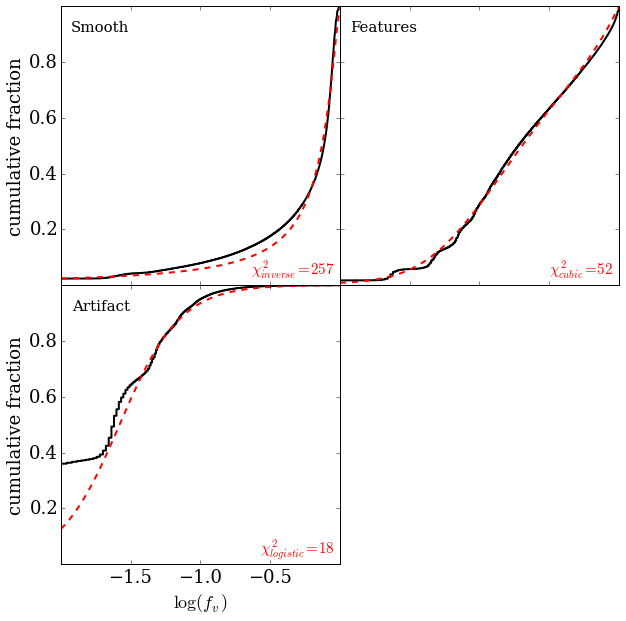

In [56]:
fit_setup = make_setup_dictionary(question,questions)

In [108]:
def function_inversion(value,func,k,kb,c,cb):
    # for use when function has no mathematical inverse
    xg = np.log10(np.linspace(0.01,1,100))
    low_z_values = func(xg,kb,cb)
    high_z_value = func(value,k,c)
    i = (np.abs(low_z_values-high_z_value)).argmin()
    x = xg[i]
    return x

def f_inv(x,k,c):
    # Function to fit the data bin output from the raw plot function
    r = 1/(1 + k*((-x))**c)
    return r

def i_f_exp_pow(y, k, c):
    # inverse of f_exp_pow
    ok = k > 0
    x = np.zeros_like(y) - np.inf
    #x[ok] = -(-np.log(y[ok]) /k[ok] )**(1.0/c[ok])
    return x